# Кластеризация. Домашнее задание

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

#%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (12, 9)

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation
from sklearn.metrics import adjusted_rand_score, silhouette_score

from matplotlib.colors import Colormap

In [2]:
df = pd.read_excel('geo.xlsx')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108806 entries, 0 to 108805
Data columns (total 4 columns):
Unnamed: 0       108806 non-null int64
x                108806 non-null float64
y                108806 non-null float64
comment_class    108806 non-null int64
dtypes: float64(2), int64(2)
memory usage: 3.3 MB


### Преобразуем данные

In [4]:
df.drop('Unnamed: 0', axis=1, inplace=True)

scaler = StandardScaler()
df.x = scaler.fit_transform(df[['x']])
df.y = scaler.fit_transform(df[['y']])

df.head()

,x,y,comment_class
0,0.367919,0.159553,-1
1,0.367919,0.159553,-1
2,0.293178,-0.348131,-1
3,-0.073819,-0.539880,-1
4,-0.009022,-0.496273,-1


#### Задание 1. Визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку) 

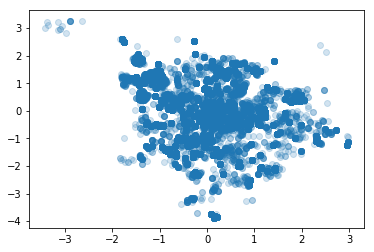

In [5]:
X = df[['x','y']].to_numpy()
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)

In [6]:
def get_optimal_cluster(k_inertia, ks):
    diff = np.diff(k_inertia)
    diff_r = diff[1:] / diff[:-1]
    k_opt = ks[np.argmin(diff_r)+1]
    return k_opt

def get_kmeans_clusters(df, n_max_clusters=10):
    # make optimal KMeans clusters
    k_inertia = []
    l_silhouette = []
    ks = range(2, n_max_clusters)

    for k in ks:
        clf_kmeans = KMeans(n_clusters=k)
        clusters_kmeans = clf_kmeans.fit_predict(df)
        k_inertia.append(clf_kmeans.inertia_)
        #l_silhouette.append(silhouette_score(X=df, labels=clusters_kmeans))

    plt.plot(ks, k_inertia)
    #plt.plot(ks, l_silhouette)
    return get_optimal_cluster(k_inertia, ks)

In [7]:
def plot_cluster(algorithm, X, alpha=0.3, cmap=None):
    clusters = algorithm.fit_predict(X)
    
    plt.scatter(X[:, 0], X[:, 1], c=clusters, alpha=alpha, cmap=cmap)
    
    if algorithm.__class__.__name__ in {'KMeans'}:
        centers = algorithm.cluster_centers_
        plt.scatter(centers[:, 0], centers[:, 1], s=50)
    plt.title(algorithm.__class__.__name__)

Оптимальное число кластеров по kmeans : 8


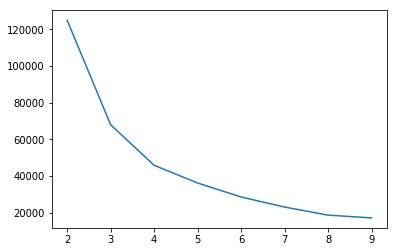

In [8]:
n_optimal_clusters = get_kmeans_clusters(X)
print(f'Оптимальное число кластеров по kmeans : {n_optimal_clusters}')

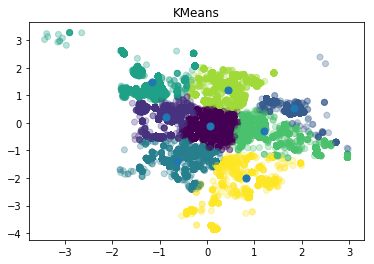

In [9]:
plot_cluster(KMeans(n_optimal_clusters), X)

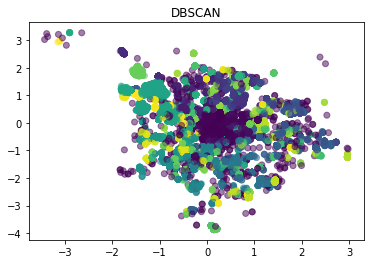

In [10]:
plot_cluster(DBSCAN(eps=0.05, min_samples=3), X, alpha=0.5)

In [11]:
#plot_cluster(AffinityPropagation(), X, alpha=0.5)

In [12]:
#plot_cluster(AgglomerativeClustering(n_clusters=n_optimal_clusters), X, alpha=0.5)

#### Задание 2. Аналогично исследовать скопления голосов за и против отдельно
#### Начнем за тех, кто за

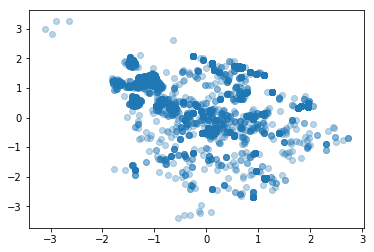

In [13]:
X = df[df['comment_class'] == 1][['x','y']].to_numpy()
plt.scatter(X[:, 0], X[:, 1], alpha=0.3)

Оптимальное число кластеров по kmeans : 3


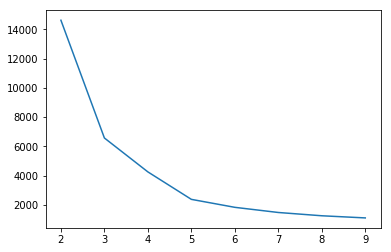

In [14]:
n_optimal_clusters = get_kmeans_clusters(X)
print(f'Оптимальное число кластеров по kmeans : {n_optimal_clusters}')

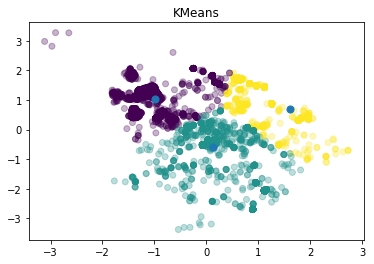

In [15]:
plot_cluster(KMeans(n_optimal_clusters), X)

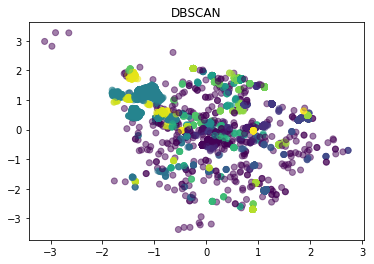

In [16]:
plot_cluster(DBSCAN(eps=0.05, min_samples=3), X, alpha=0.5)

#### Теперь посмотрим на тех, кто против

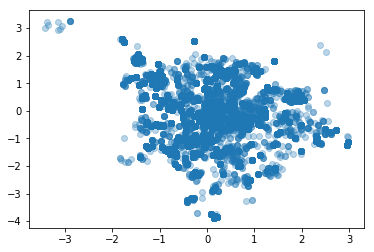

In [17]:
# посчитаем тех, кто за
X = df[df['comment_class'] == -1][['x','y']].to_numpy()
plt.scatter(X[:, 0], X[:, 1], alpha=0.3)

Оптимальное число кластеров по kmeans : 3


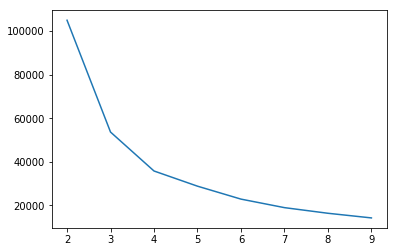

In [18]:
n_optimal_clusters = get_kmeans_clusters(X)
print(f'Оптимальное число кластеров по kmeans : {n_optimal_clusters}')

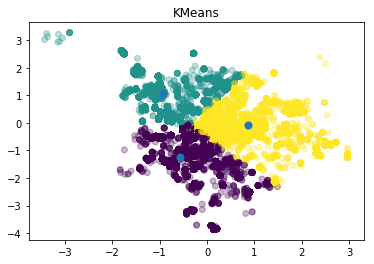

In [19]:
plot_cluster(KMeans(n_optimal_clusters), X)

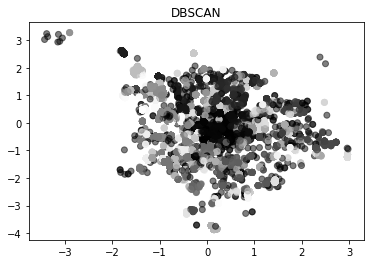

In [20]:
plot_cluster(DBSCAN(eps=0.05, min_samples=3), X, alpha=0.5, cmap='gray')

Принципиальных отличий между общим датасетом и разделенным на за и против выявлено не было

#### Задание 3. Подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)
Сделал внутри предыдущих заданий

#### Дополнительное задание
Найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*

In [21]:
X = df[['x','y']].to_numpy()

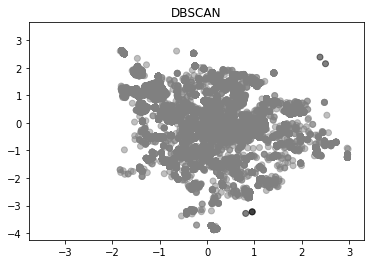

In [22]:
plot_cluster(DBSCAN(eps=0.5, min_samples=10), X, alpha=0.5, cmap='gray')

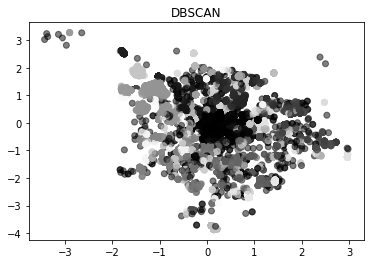

In [23]:
plot_cluster(DBSCAN(eps=0.05, min_samples=3), X, alpha=0.5, cmap='gray')

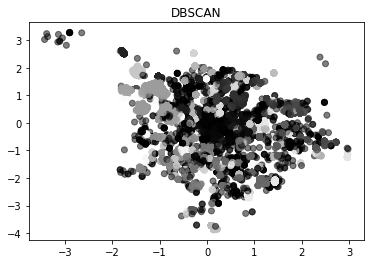

In [24]:
plot_cluster(DBSCAN(eps=0.05, min_samples=7), X, alpha=0.5, cmap='gray')

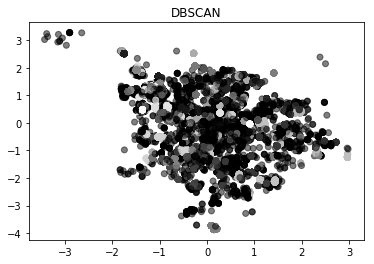

In [25]:
plot_cluster(DBSCAN(eps=0.01, min_samples=10), X, alpha=0.5, cmap='gray')

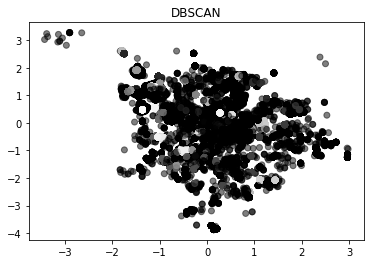

In [26]:
plot_cluster(DBSCAN(eps=0.001, min_samples=100), X, alpha=0.5, cmap='gray')

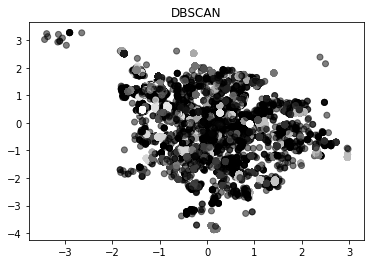

In [27]:
plot_cluster(DBSCAN(eps=0.001, min_samples=10), X, alpha=0.5, cmap='gray')

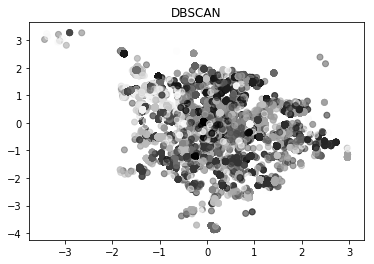

In [28]:
plot_cluster(DBSCAN(eps=0.001, min_samples=1), X, alpha=0.5, cmap='gray')

Найти оптимальные параметры для DBSCAN - действительно интересная исследовательская задача